In [78]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [107]:
import numpy as np
import sys
import pickle
sys.path.append('/home1/efeghhi/ripple_memory/analysis_code/pac_analyses/')
from load_data_numpy import load_data_np
from matplotlib import pyplot as plt
from comodulogram import remove_session_string, get_filtered_signal
from scipy.stats import pearsonr
import pandas as pd
from scipy.stats import wilcoxon


In [81]:
catFR1_encoding = pd.read_pickle("/scratch/efeghhi/catFR1/ENCODING/SWR_catFR1_R1683A_0_HPC_encoding_soz_in_hamming.p")

In [82]:
catFR1_encoding.keys()

dict_keys(['region_electrode_ct', 'elec_names', 'sub_sess_names', 'raw_eeg', 'ripple_array', 'time_add_save', 'trial_nums', 'encoded_word_key_array', 'category_array', 'serialpos_array', 'list_recall_num_array', 'rectime_array', 'session_events', 'recall_position_array', 'fr_array', 'sub_names', 'total_recalls', 'kept_recalls', 'trial_by_trial_correlation', 'elec_by_elec_correlation', 'elec_ripple_rate_array', 'semantic_clustering_key', 'temporal_clustering_key', 'semantic_clustering_from_key', 'serialpos_lags', 'serialpos_from_lags', 'CRP_lags', 'list_trial_nums', 'list_num_key', 'list_level_semantic', 'list_level_temporal', 'electrode_labels', 'channel_coords'])

In [83]:
len(catFR1_encoding['list_num_key'])

864

In [84]:
len(catFR1_encoding['category_array'])

864

### Load data

In [85]:
encoding_mode = 1 # 1 for encoding, 0 for recall
region_name = ['HPC']
subregion = ['ca1']
dd_trials = load_data_np(encoding_mode, region_name=region_name, subregion=subregion)

Loading data
LOADING DATA FROM:  HPC
order: C


In [86]:
subjects = dd_trials['subj']
clustered = dd_trials['clust_int']
correct = dd_trials['correct']
cat_array = dd_trials['category_array']
unique_subjects = np.unique(subjects)
subj_elec_labels = np.array([remove_session_string(x) for x in dd_trials['elec_labels']])
subj_elec_labels_unique = np.unique(subj_elec_labels)
electrode_count_per_subject = {}
for s in unique_subjects:
    electrode_count_per_subject[s] = 0
    for se in subj_elec_labels_unique:
        if s in se:
            electrode_count_per_subject[s] += 1

In [103]:
s_i_all_subjects = []
frac_intrusions_out_of_all = []
frac_correct_out_of_all = []
low_perf_subjects = []
for us in unique_subjects:

    subject_idxs = np.argwhere(subjects==us)
    clustered_s = clustered[subject_idxs]
    s_i = compute_fraction_clustered(clustered_s)
    correct_s = correct[subject_idxs]
    frac_correct_s = np.mean(correct_s)
    
    if frac_correct_s < 0.15:
        low_perf_subjects.append(us)
        continue

    s_i_all_subjects.append(s_i)
    frac_correct_out_of_all.append(frac_correct_s)

In [104]:
low_perf_subjects

['R1260D', 'R1338T', 'R1368T']

### Is the first or second item in a semantic pair more likely to be clustered?
- Label each item in the list as the first or second item in the semantic pair 
- Take every item that is clustered, see if it was the first or second item in the pair 

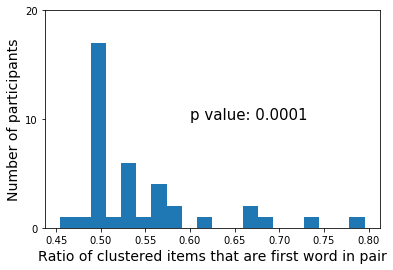

In [119]:
# positions 0,2,4,6,8,10 are first in the semantic pair
# positions 1,3,5,7,11 are second in the semantic pair 
first_in_semantic_pair = np.zeros(cat_array.shape[0])
first_in_semantic_pair[::2] = 1


ratio_clustered_first_pair_subjects = []
for s in unique_subjects:
    
    if s in low_perf_subjects:
        continue
    
    clust_and_fsp = 0 # clustered and first in semantic pair
    clust_and_ssp = 0 # clustered and second in semantic pair 
    
    subj_idxs = np.argwhere(subjects==s)
    
    # now loop through clustered and first_in_semantic pair
    for fsp, clust in zip(first_in_semantic_pair[subj_idxs].squeeze(), clustered_array[subj_idxs].squeeze()):

        if clust > 1 and fsp == 1:
            clust_and_fsp+=1
        if clust > 1 and fsp == 0:
            clust_and_ssp+=1
            
    ratio_clustered_first_pair_subjects.append(clust_and_fsp / (clust_and_fsp+clust_and_ssp))

    plt.show()

differences = np.array(ratio_clustered_first_pair_subjects)-0.5
stat, p_value = wilcoxon(differences, alternative='greater')

plt.hist(ratio_clustered_first_pair_subjects, bins=20)
plt.xlabel("Ratio of clustered items that are first word in pair", fontsize=14)
plt.ylabel("Number of participants", fontsize=14)
plt.text(0.6, 10, f'p value: {round(p_value,4)}', fontsize=15)
plt.yticks([0, 10, 20])
plt.show()

        

In [5]:
def compute_fraction_clustered(clust_int_subj):
    
    total_trials = clust_int_subj.shape[0]
    # a word follows, and it is semantically and/or temporally related
    num_clustered = np.argwhere(clust_int_subj > 0).shape[0]
    # a word follows, but not semantically or temporally related 
    num_not_clustered = np.argwhere(clust_int_subj == -1).shape[0] 
    s_i = num_clustered/(num_clustered+num_not_clustered)
    return s_i

### Is there a correlation between the percentage of recalls that are clustered and the number of correctly recalled items?

In [8]:
len(low_perf_subjects)

14

0.084


Text(0, 0.5, 'S_i')

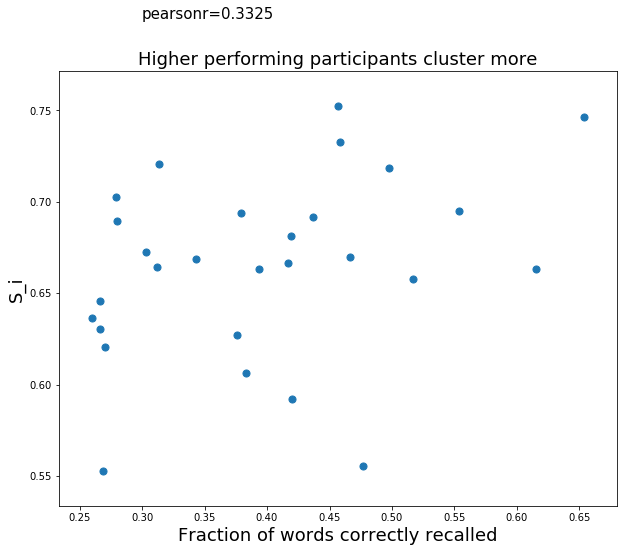

In [9]:
plt.figure(figsize=(10,8))
plt.scatter(frac_correct_out_of_all, s_i_all_subjects, s=50)
r,p = pearsonr(frac_correct_out_of_all, s_i_all_subjects)
print(round(p,3))
plt.text(0.3, 0.8, f"pearsonr={round(r,4)}", fontsize=15)
plt.title("Higher performing participants cluster more", fontsize=18)
plt.xlabel("Fraction of words correctly recalled", fontsize=18)
plt.ylabel("S_i", fontsize=18)


In [54]:
dd_trials['clust']

array([array(['D', 'C', 'C', 'D', 'C', 'Z'], dtype='<U1'),
       array(['D', 'C', 'C', 'D', 'C', 'Z'], dtype='<U1'),
       array(['D', 'C', 'C', 'D', 'C', 'Z'], dtype='<U1'), ...,
       array(['I', 'I', 'Z'], dtype='<U1'),
       array(['I', 'I', 'Z'], dtype='<U1'),
       array(['I', 'I', 'Z'], dtype='<U1')], dtype=object)

### Do participants which recall more words/cluster more often show higher hippocampal engagement during word processing?

In [79]:
def z_score(power):
    # mean center by mean across time and trials 
    # then divide by standard deviation of the average across timesteps
    power = (power - np.mean(power)) / np.std(np.mean(power, axis=1),axis=0)
    return power

def process_power(power, zscore_by_idxs):
    
    from scipy.signal import decimate
    
    power_ds = decimate(np.log10(power), 10)
    
    power_ds_zscored = np.zeros_like(power_ds)
    
    for subj_elec in np.unique(zscore_by_idxs):
        
        subj_elec_idxs = np.argwhere(zscore_by_idxs==subj_elec).squeeze()
            
        for freq in range(power_ds.shape[0]):

            power_ds_zscored[freq, subj_elec_idxs] = z_score(power_ds[freq, subj_elec_idxs].squeeze())
        
    return power_ds_zscored

In [99]:
raw_data = dd_trials['raw']
freq = 'low'
if freq == 'low':
    freq_range = [[2,4]]
    axis_title = 'theta'
if freq == 'high':
    freq_range = [[80,120]]
    axis_title = 'gamma'
    
bandwidth = 'auto'
if encoding_mode:
    start_cutoff = 500
    end_cutoff = 2000
fs = 500

In [100]:
filtered_sig = get_filtered_signal(raw_data, freq_range, start_cutoff, 
                                   end_cutoff, fs, bandwidth=bandwidth)

In [101]:
filtered_power = (np.real(np.abs(filtered_sig))**2)
power_z = process_power(filtered_power, subj_elec_labels)

In [102]:
power_z.shape

(1, 55356, 150)

In [103]:
power_z = power_z.squeeze()

In [110]:
start_time = -700
end_time = 2000
start_roi = 300
end_roi = 1300
sr_factor = 1000/50
start_idx = int((start_roi - start_time)/sr_factor)
end_idx = int((end_roi-start_time)/sr_factor)
print(start_idx, end_idx)

50 100


0.550518412595156


Text(0, 0.5, 'theta power (z) 400-1100 ms post word onset')

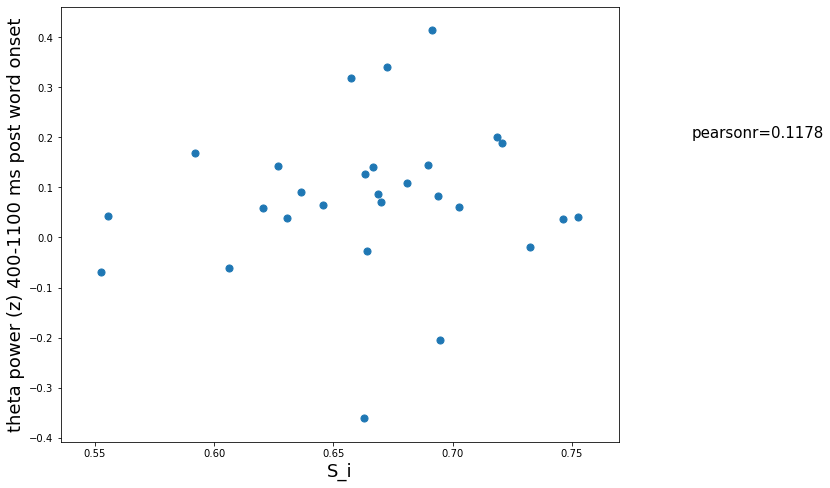

In [116]:
time_avg_power_subjs = []
for us in unique_subjects:
    if us in low_perf_subjects:
        continue
    subject_idxs = np.argwhere(subjects==us).squeeze()
    subject_time_averaged = np.mean(power_z[subject_idxs].squeeze(), axis=0)
    time_avg_power_subjs.append(subject_time_averaged)
time_avg_power_subjs_np = np.vstack(time_avg_power_subjs)

gp_avg = np.mean(time_avg_power_subjs_np[:, start_idx:end_idx].squeeze(),axis=1).squeeze()
r,p =pearsonr(s_i_all_subjects, gp_avg)
plt.figure(figsize=(10,8))
plt.scatter(s_i_all_subjects, gp_avg, s=50)
plt.text(0.8,0.2,f"pearsonr={round(r,4)}", fontsize=15)
print(p)
plt.xlabel("S_i", fontsize=18)
plt.ylabel(f"{axis_title} power (z) 400-1100 ms post word onset", fontsize=18)

Text(0, 0.5, 'theta power (z) 400-1100 ms post word onset')

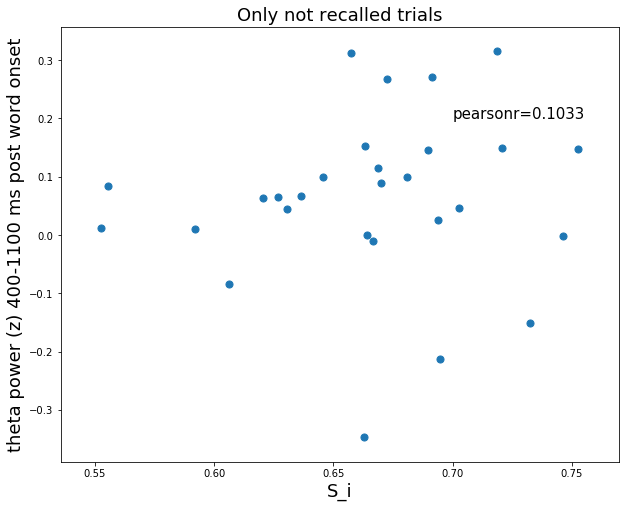

In [117]:
time_avg_power_subjs_not_recalled = []
not_recalled_idxs = np.argwhere(correct==0).squeeze()
for us in unique_subjects:
    
    if us in low_perf_subjects:
        continue
        
    subject_idxs = np.argwhere(subjects==us)
    incorrect_subject_idxs = np.intersect1d(subject_idxs, not_recalled_idxs)
    
    subject_time_averaged_nr = np.mean(power_z[incorrect_subject_idxs].squeeze(), axis=0)
    time_avg_power_subjs_not_recalled.append(subject_time_averaged_nr)
    
time_avg_power_subjs_not_recalled_np = np.vstack(time_avg_power_subjs_not_recalled)
plt.figure(figsize=(10,8))
gp_not_recalled_avg = np.mean(time_avg_power_subjs_not_recalled_np[:, start_idx:end_idx],axis=1).squeeze()
r,p =pearsonr(s_i_all_subjects, gp_not_recalled_avg)
plt.scatter(s_i_all_subjects, gp_not_recalled_avg, s=50)
plt.text(0.7,0.2,f"pearsonr={round(r,4)}", fontsize=15)
plt.title("Only not recalled trials", fontsize=18)
plt.xlabel("S_i", fontsize=18)
plt.ylabel(f"{axis_title} power (z) 400-1100 ms post word onset", fontsize=18)